# 5. Explore communication by exRNA

Transcripts located outside segmented cells are more likely to play a role in celular communication, being located outside their cell of origin and close to other populations. Thus, in the following notebook we aim to explore the commnunication patterns where exRNA could be involved

## Import packages

In [1]:
import pandas as pd
import spatialdata as sd
import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Read SpatialData object

In [3]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
output_path = "/media/sergio/Discovair_final/analysis_crop"
sdata = sd.read_zarr(xenium_path_cropped)

# 1. Identify source cell of exRNA

We will use the function `compute_source_cells` to identify the source cell types that may contribute to the extracellular RNA detected in spatial transcriptomics data. For this, we use an expression threshold to determine which transcripts are expressed and computes the proportion of cells expressing each gene per cell type.

In [ ]:
troutpy.tl.compute_source_score(sdata,layer="transcripts",gene_id_column="feature_name",xcoord="x",
ycoord="y",lambda_decay=0.1, copy=False,celltype_key='cell type')

#### PLOTTING FUNCTION 1 (troutpy.pl)- source cell heatmap
- **Aim**: Represent the aggregated source cell type by targetgene
- **Input**: sdata,specifically `sdata['source_score'], contianing source score for each exRNa-cell type
- **Suggested Type of plot**: Heatmap (gene x cell types)
-  **Returns**: None (besides the plot) 


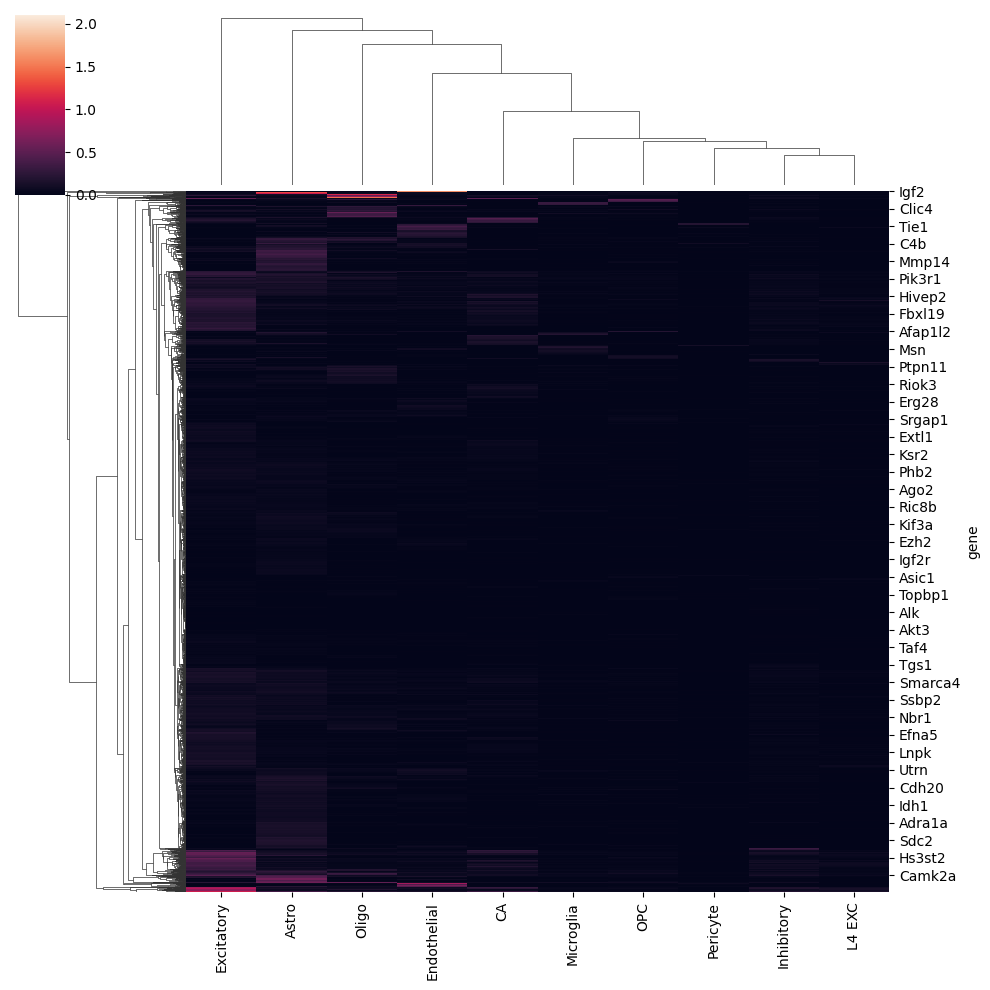

In [29]:
### Example code - maybe we want to just visualize some genes
gene_key='feature_name'
min_counts=100
source_score=sdata['source_score'].to_df()
source_score['gene']=sdata['source_score'].obs[gene_key]
gene_by_celltype_score=source_score.groupby('gene').mean()
genes=sdata['xrna_metadata'].var.index[ sdata['xrna_metadata'].var['count']> min_counts]
filtered_gene_by_celltype_score=gene_by_celltype_score.loc[gene_by_celltype_score.index.isin(genes),:]
import seaborn as sns
sns.clustermap(filtered_gene_by_celltype_score)

# Similar visualization- functions from previous version of the code
# troutpy.pl.sorted_heatmap(source_proportion, output_path,filename="Heatmap_source_cells_by_gene.pdf",cmap='Blues',vmax=0.2)
# troutpy.pl.sorted_heatmap(absent_source_proportions, output_path,filename="Heatmap_source_cells_by_gene.pdf",cmap='Blues',vmax=1,figsize=(4,3))

### 1.1 Compute distance to source cell

After computing the distance between each cell and its source, we can quantify the proportion of extracellular transcripts located away (distant transcripts) from its closest source. For this, we define a threshold distance ( in micrometers), which will be the minimum distance from each transcript to its source to consider a transcript distance. To compute the proportion of distant transcripts, we will employ the function ``troutpy.tl.compute_distant_cells_prortion``

In [31]:
troutpy.tl.compute_distant_cells_proportion(sdata, gene_id_column="feature_name", threshold=30, copy=False)

Originally we developed a function to plot this, but we could use the same one as we expect to develop to quantify RNA. Specifically
 
**PLOTTING FUNCTION 2 (troutpy.pl) Sorted scatterplot/barplot**

## 2. Identify target cell of each exRNA

Once we have explored the potential source cell of each extracellular transcript, we can also expore the most likely target cell of each exRNA analyzed. For this, we will employ ``troutpy.tl.compute_target_score``. Essentially, this function will compute the distance to its closest cells for each exRNA, using a decay function, based on lambda decay. Of course, we can't be sure that communication will occur with the closest cells. However, in case exRNA plays a role in cell-cell communication, the most likely target cell of each exRNA will be its closest cell. 

In [ ]:
troutpy.tl.compute_target_score(sdata, layer="transcripts", gene_id_column="feature_name", xcoord="x",
ycoord="y", xcellcoord="x_centroid", ycellcoord="y_centroid", lambda_decay=0.1,
copy=False, celltype_key="cell type")

For representing the target cell scores, ideally we could use the source cell heatmap function (to be implemented above)
**PLOTTING FUNCTION 1 (troutpy.pl)- source cell heatmap**

### 2.1 Saving sdata as .zarr

We next save the object as zarr

In [31]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr). Please see   
         the documentation of `is_self_contained()` to understand the implications of working with SpatialData     
         objects that are not self-contained.                                                                      
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr the new file path:                 
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr                                  


# 3. Communication 

In [40]:
sdata['source_score']

AnnData object with n_obs × n_vars = 834299 × 10
    obs: 'feature_name', 'distance', 'closest_cell', 'closest_celltype'
    uns: 'gene_interaction_names', 'gene_interaction_strength', 'interaction_strength'
    obsm: 'spatial'

After we have computed source and target scores, we can explore communication. For this, we will compute the possibility of interaction, per extracellular transcript. This is step is achieved using ```troutpy.tl.compute_communication_strength```. Results are stored under ```sdata['source_score'].uns['interaction_strenght']``` and is a 3D matrix, where we have the communication scores for each transcript and each pair of cell types (exRNA,CT,CT)
*the location of this is temporary until we find a better place to store it*

In [27]:
troutpy.tl.compute_communication_strength(sdata)

100%|█████████████████████████████████████████████████████████████████████████| 834299/834299 [03:51<00:00, 3607.83it/s]


Next, we will compile all scores by gene (G), using ```troutpy.tl.gene_specific_interactions```. The resulting 3D matrix (G,CT,CT), will be stored in ```sdata['source_score'].uns['gene_interaction_strenght']```. Gene names corresponding to the first dimension will be stored in ```sdata['source_score'].uns['gene_interaction_names']```

In [29]:
troutpy.tl.gene_specific_interactions(sdata, copy=False)

Processing categories: 100%|████████████████████████████████████████████████████████| 5566/5566 [14:23<00:00,  6.44it/s]


## --TO DO--  Plotting functions for interactions

#### PLOTTING FUNCTION 3 (troutpy.pl)- plot_celltype_interactions
- **Aim**: Represent the aggregated interaction score by cell type
- **Input**: sdata,specifically `sdata['source_score'].uns['interaction_strength']` and `sdata['target_score']`
- **Suggested Type of plot**: Heatmap or chord plot
-  **Returns**: None (besides the plot) 

An initial version of this function can be found below

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_chord_diagram import chord_diagram

def plot_celltype_communication(sdata, kind='heatmap', celltype_key='cell type', vmax=None, vmin=None, cmap='BuPu',
                              dendrogram_ratio=0.1,**kwargs):
    """
    Plot cell type-cell type interaction strength as a heatmap or chord diagram.
    
    Parameters:
    sdata : SpatialData object
        The spatial data object containing interaction scores.
    kind : str, optional
        Type of plot, either 'heatmap' or 'chord'. Default is 'heatmap'.
    celltype_key : str, optional
        Key for cell type colors in `sdata['table'].uns`. Default is 'cell type'.
    vmax : float, optional
        Max value for colormap scaling. Default is None.
    vmin : float, optional
        Min value for colormap scaling. Default is None.
    cmap : str, optional
        Colormap for heatmap or chord diagram. Default is 'BuPu'.
    **kwargs : dict
        Additional arguments passed to the plotting functions.
    """
    interaction_strength = sdata['source_score'].uns['interaction_strength']
    source_table = sdata['source_score']
    target_table = sdata['target_score']
    
    celltype_ints = np.mean(interaction_strength, axis=0)
    celltype_ints_table = pd.DataFrame(celltype_ints, index=source_table.var.index, columns=target_table.var.index)
    
    try:
        colors = sdata['table'].uns[celltype_key + '_colors']
    except KeyError:
        colpalette = plt.get_cmap("tab20")
        colors = [colpalette(i) for i in range(len(np.unique(source_table.var.index)))]
    
    if kind == 'heatmap':
        sns.clustermap(celltype_ints_table, vmax=vmax, vmin=vmin, cmap=cmap, row_colors=colors, col_colors=colors,
                       dendrogram_ratio=dendrogram_ratio, **kwargs).fig.suptitle('Interaction strenght') 
    
    elif kind == 'chord':
        chord_diagram(
            celltype_ints,
            source_table.var.index,
            directed=True,
            fontsize=10,
            colors=colors,
            **kwargs
        )
        plt.title('Interaction Strength', fontweight="bold")
    else:
        raise ValueError("Invalid plot type. Choose 'heatmap' or 'chord'.")
    
    plt.show()


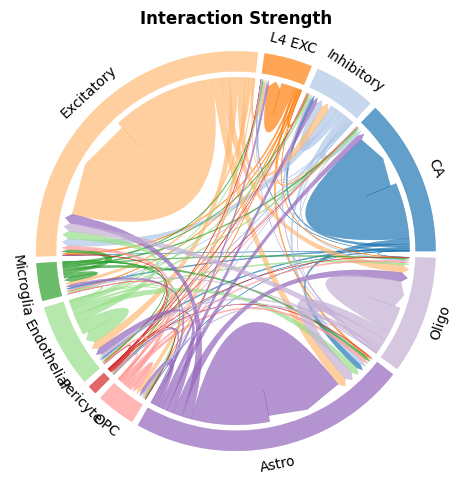

In [58]:
plot_celltype_communication(sdata, kind='chord', celltype_key='cell type', vmax=None, vmin=None, cmap='BuPu',figsize=(5,5),cbar_pos=(.001, .42, .003, .2),
linewidths=.75)

#### PLOTTING FUNCTION 4 (troutpy.pl)- plot interactions for 1 specific gene
- **Aim**: Represent the aggregated interaction score by cell type
- **Input**: gene_name(str),sdata,specifically `sdata['source_score'].uns['interaction_strength']` and `sdata['target_score']`
- **Suggested Type of plot**: Heatmap or chord plot
-  **Returns**: None (besides the plot) 

An initial version of this function can be found below

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from spatialdata import SpatialData
from mpl_chord_diagram import chord_diagram

def plot_gene_communication(sdata:SpatialData, kind='heatmap',gene:str='', celltype_key='cell type', vmax=None, vmin=None, cmap='BuPu',
                              dendrogram_ratio=0.1,**kwargs):
    """
    Plot cell type-cell type interaction strength as a heatmap or chord diagram.
    
    Parameters:
    sdata : SpatialData object
        The spatial data object containing interaction scores.
    kind : str, optional
        Type of plot, either 'heatmap' or 'chord'. Default is 'heatmap'.
    celltype_key : str, optional
        Key for cell type colors in `sdata['table'].uns`. Default is 'cell type'.
    gene
        Name of the gene to be plotted
    vmax : float, optional
        Max value for colormap scaling. Default is None.
    vmin : float, optional
        Min value for colormap scaling. Default is None.
    cmap : str, optional
        Colormap for heatmap or chord diagram. Default is 'BuPu'.
    **kwargs : dict
        Additional arguments passed to the plotting functions.
    """
    gene_interaction_strength = sdata['source_score'].uns['gene_interaction_strength']
    source_table = sdata['source_score']
    target_table = sdata['target_score']
    unique_cats=sdata.tables['source_score'].uns['gene_interaction_names']
    if str(gene) not in unique_cats:
        raise KeyError('Gene name not found in the dataset')
    celltype_ints_table=pd.DataFrame(gene_interaction_strength[(unique_cats==gene),:,:].squeeze(),index=source_table.var.index,columns=target_table.var.index)
    try:
        colors = sdata['table'].uns[celltype_key + '_colors']
    except:
        colpalette = plt.get_cmap("tab20")
        colors = [colpalette(i) for i in range(len(np.unique(source_table.var.index)))]
    
    if kind == 'heatmap':
        sns.clustermap(celltype_ints_table, vmax=vmax, vmin=vmin, cmap=cmap, row_colors=colors, col_colors=colors,
                       dendrogram_ratio=dendrogram_ratio, **kwargs).fig.suptitle('Interaction strenght') 
    elif kind == 'chord':
        chord_diagram(
            gene_interaction_strength[(unique_cats==gene),:,:].squeeze(),
            source_table.var.index,
            directed=True,
            fontsize=10,
            colors=colors,
            **kwargs
        )
        plt.title(str(gene) +'Interaction Strength', fontweight="bold")
    else:
        raise ValueError("Invalid plot type. Choose 'heatmap' or 'chord'.")
    
    plt.show()


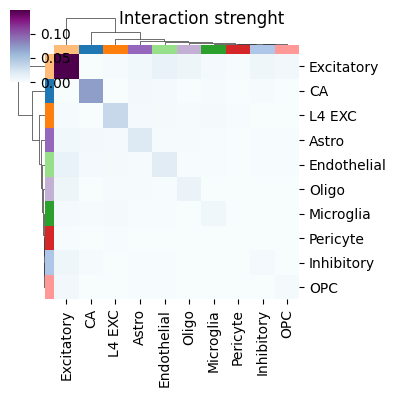

In [63]:
plot_gene_communication(sdata, kind='heatmap',gene='Arc',figsize=(4,4))

# 4. Further develop-  Directionality analysis

We are trying to develop strategies to explore wether exRNa are homogeneusly distributed arround it's source in a "diffusion" pattern, or if it present certain directionally. 

In [93]:
from spatialdata import SpatialData 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_transcript_distribution_with_edge_correction(
    sdata: SpatialData,
    layer="transcripts",
    gene_id_column="feature_name",
    xcoord="x",
    ycoord="y",
    xcellcoord="x_centroid",
    ycellcoord="y_centroid",
    resolution=12,
    max_distance=50,
    edge_buffer=20,
    radius=30,  # New parameter: radius to consider for nearby transcripts
    copy=False,
):
    """
    Analyzes the extracellular distribution of transcripts for diffusion patterns and directionality,
    accounting for edge effects. Now, it considers only transcripts within a certain radius from each cell.

    Parameters
    ----------
    - radius (float, optional)
        Maximum distance (radius) from each cell to consider relevant transcripts. Default is 10 units.
    - edge_buffer (float, optional)
        Minimum distance from the boundary for cells to be included in the analysis. Default is 20 units.
    """
    # Extract spatial bounds of the region
    transcripts = sdata.points[layer].compute()
    cells = sdata["table"].to_df()
    coord_cells = sdata["table"].obsm["spatial"]
    transcripts = transcripts[transcripts["extracellular"] == False]
    
    # Get spatial bounds
    x_min, y_min = coord_cells.min(axis=0)
    x_max, y_max = coord_cells.max(axis=0)

    # Filter edge cells
    edge_mask = (
        (coord_cells[:, 0] > x_min + edge_buffer)
        & (coord_cells[:, 0] < x_max - edge_buffer)
        & (coord_cells[:, 1] > y_min + edge_buffer)
        & (coord_cells[:, 1] < y_max - edge_buffer)
    )
    valid_cells = cells[edge_mask]
    valid_coords = coord_cells[edge_mask]

    # Initialize results
    results = []

    for gene in tqdm(cells.columns.unique(), desc="Processing genes"):
        # Filter transcripts and edge-corrected cells for the current gene
        gene_transcripts = transcripts[transcripts[gene_id_column] == gene]
        gene_cells = valid_cells[valid_cells[gene] > 0]
        if gene_transcripts.empty or gene_cells.empty:
            continue

        # Extract coordinates
        transcript_coords = gene_transcripts[[xcoord, ycoord]].to_numpy()
        cell_coords = valid_coords[valid_cells[gene] > 0]

        # Radial distribution with edge correction (only for relevant transcripts within radius)
        radial_bins = np.linspace(0, max_distance, 50)
        radial_density = np.zeros_like(radial_bins[:-1], dtype=float)
        
        for cell_idx, cell_coord in enumerate(cell_coords):
            # Find transcripts within the specified radius around the current cell
            dists_to_transcripts = np.linalg.norm(transcript_coords - cell_coord, axis=1)
            relevant_transcripts = transcript_coords[dists_to_transcripts <= radius]  # Filter by distance
            
            if relevant_transcripts.shape[0] == 0:  # No transcripts in range
                continue
            
            # Compute distances to relevant transcripts
            dists = dists_to_transcripts[dists_to_transcripts <= radius]
            
            # Add the histogram of distances for this cell
            radial_density += np.histogram(dists, bins=radial_bins, density=True)[0]

        radial_density /= len(cell_coords)  # Normalize by the number of valid cells

        # Symmetry score
        decay_model = np.exp(-radial_bins[:-1] / (max_distance / 2))
        symmetry_score = np.corrcoef(radial_density, decay_model)[0, 1]

        # Directionality analysis with angular density
        angles = np.arctan2(
            transcript_coords[:, 1][:, None] - cell_coords[:, 1],
            transcript_coords[:, 0][:, None] - cell_coords[:, 0],
        )
        angles = angles % (2 * np.pi)
        angular_bins = np.linspace(0, 2 * np.pi, resolution + 1)
        angular_density = np.zeros(resolution, dtype=float)
        for sector_idx in range(resolution):
            sector_mask = (
                (angles >= angular_bins[sector_idx])
                & (angles < angular_bins[sector_idx + 1])
            )
            angular_density[sector_idx] = sector_mask.sum() / transcript_coords.shape[0]
        
        # Directionality score
        directionality_score = np.var(angular_density)
        #if directionality_score>1000:
        #    plt.figure()
        #    sns.barplot(angular_density)
        #    plt.title(gene)
        #    plt.show()



        # Store results
        results.append({
            "gene": gene,
            "symmetry_score": symmetry_score,
            "directionality_score": directionality_score,
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    if copy:
        return sdata.copy(), results_df
    else:
        return results_df

In [ ]:
results_df=analyze_transcript_distribution_with_edge_correction(
    sdata, layer="transcripts", gene_id_column="feature_name",
 xcoord="x", ycoord="y",xcellcoord="x_centroid",ycellcoord="y_centroid",
    resolution=12, max_distance=50, edge_buffer=20, copy=False)

# 5. Additional plotting for communication [DEPR]

This section includes plots that were developed for previous versions of the package. Some of them might be interesting

In [ ]:
def communicating_genes_per_celltype(sdata, proportion_threshold: float = 0.2, cell_type_key="cell type"):
    """Computes the number of significant genes exchanged between source and target cell types based on their proportions in the dataset.

    Parameters
    ----------
    - sdata: AnnData object
    A spatial data object containing the 'table' and 'xrna_metadata' components.
    - proportion_threshold: float, optional (default=0.2)
    The threshold for filtering significant gene proportions. Genes with proportions above this value are considered significant.
    - cell_type_key: str, optional (default='cell type')
    The key in `adata.obs` that contains the cell type annotations.

    Returns
    -------
    - number_interactions_df: pandas.DataFrame
    A DataFrame where rows represent source cell types, columns represent target cell types, and values indicate the number of significant genes shared between them.
    """
    adata = sdata["table"]
    source_proportions = pd.DataFrame(
        sdata["xrna_metadata"].varm["source"], index=sdata["xrna_metadata"].var.index, columns=adata.obs[cell_type_key].unique().dropna()
    )
    target_proportions = pd.DataFrame(
        sdata["xrna_metadata"].varm["target"], index=sdata["xrna_metadata"].var.index, columns=adata.obs[cell_type_key].unique().dropna()
    )

    # filter the source and target cell types by defining significant proportions
    source_binary = source_proportions > proportion_threshold
    target_binary = target_proportions > proportion_threshold

    # prepare dataframe to store the number of exchanged genes
    number_interactions_df = pd.DataFrame(index=source_binary.columns, columns=target_binary.columns)

    # loop through the source and target cell types to compute the number of
    # exchanged genes
    for col in source_binary.columns:
        sig_gene_source = source_binary.index[source_binary[col]]
        for col2 in target_binary.columns:
            sig_gene_target = target_binary.index[target_binary[col2]]
            number_interactions_df.loc[col, col2] = len(set(sig_gene_source).intersection(sig_gene_target))

    number_interactions_df = number_interactions_df[number_interactions_df.index]
    number_interactions_df.columns.name = "Target cell type"
    number_interactions_df.index.name = "Source cell type"
    return number_interactions_df

In [ ]:
communications_ngenes = communicating_genes_per_celltype(sdata, proportion_threshold=0.6, cell_type_key="cell type")

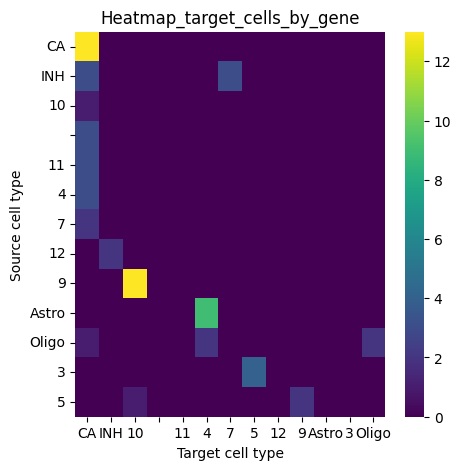

In [ ]:
troutpy.pl.sorted_heatmap(communications_ngenes.astype(float), save=False, figsize=(5, 5))

/tmp/ipykernel_1020010/2393974738.py:46: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cell_positions = pd.DataFrame(sdata['table'].obsm[spatial_key], index=sdata.table.obs[cell_id_key], columns=['x', 'y'])


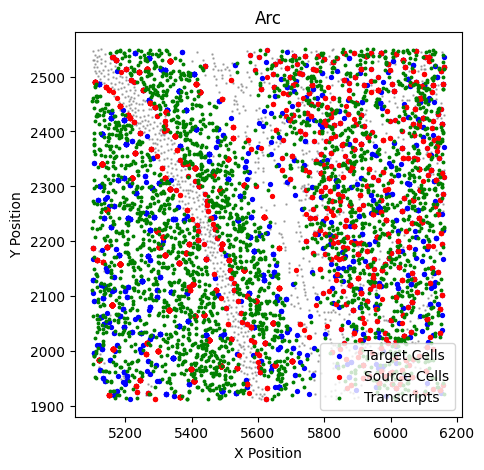

In [ ]:
troutpy.pl.spatial_interactions(sdata, layer="extracellular_transcripts_enriched", gene="Arc", gene_key="feature_name", figsize=(5, 5))

/tmp/ipykernel_1020010/732527654.py:35: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cell_positions = pd.DataFrame(sdata['table'].obsm[spatial_key], index=sdata.table.obs[cell_id_key], columns=['x', 'y'])


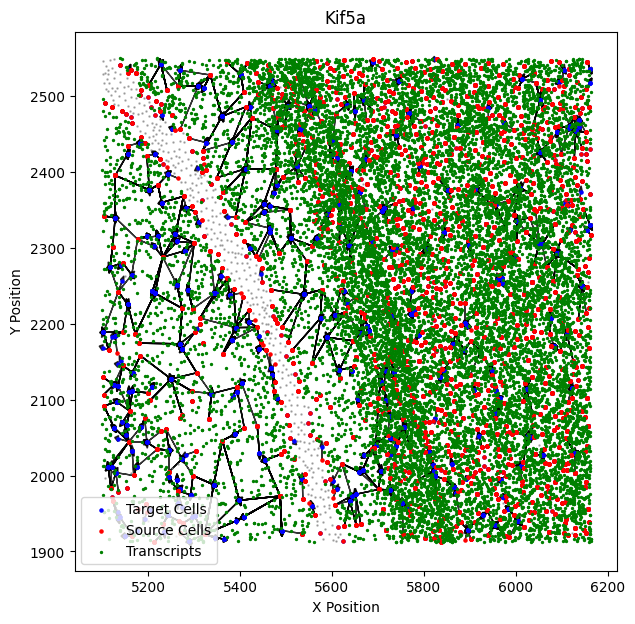

In [ ]:
troutpy.pl.interactions_with_arrows(
    sdata, layer="extracellular_transcripts_enriched", gene="Kif5a", gene_key="feature_name", figsize=(7, 7), dpi=100, size=5
)